# Deep Learning for Colombia Air Quality Forecast

![alt image of pollution](https://cdn.pixabay.com/photo/2015/01/25/18/24/industry-611668_960_720.jpg)

### Main
- Build & Train a Deep Learning model (RNN) to forecast PM 2.5 levels in Colombia's air.

### Objectives

- Develop an Exploratory Data Analysis(EDA) to find errors, relations among variables, and preliminary patterns within the data.

- Build & Train two Deep Learning model and compare their performances. 













Author: Luis Fernando Salazar S. Date: 24/04/2022

### **Colombia air quality dataset**

The Colombia air quality dataset is reported by environmental authorities to the SISAIRE (Subsistema de Información de la Calidad del Aire) from 2011 to 2017. This dataset contains 20.4 million rows and 16 columns.

Source :<a href = 'https://www.datos.gov.co/Ambiente-y-Desarrollo-Sostenible/DATOS-DE-CALIDAD-DEL-AIRE-EN-COLOMBIA-2011-2018/ysq6-ri4e'> Datos abiertos Colombia</a>

For more information, visit the following URL: http://sisaire.ideam.gov.co/ideam-sisaire-web/publicaciones.xhtml?clase=DOCUMENTOS

In [ ]:
#Import libraries
import os 
import warnings
warnings.simplefilter(action ="ignore")

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv1D, GRU, LSTM, Dense, BatchNormalization, Flatten, Dropout
from tensorflow.keras.optimizers import Nadam, Adam

#### **Input and Wrangle data**

- input data from google drive
- wrangle funtion

In [ ]:
# Wrangle funtion
def wrangle(path_file, sample_freq = 'H'):
    
    # load data
    df= pd.read_csv(path_file)
    
    # mask to variable(PM2.5)
    maks_t = df['Variable'].str.contains('PM2.5')
    
    # mask to concentration 
    mask_c = df['Concentración'] < 800
    
    # apply the masks
    df = df[maks_t & mask_c]
    
    # Drop unnecessary variables
    drop_list = ['Autoridad Ambiental',
                 'Nombre de la estación',
                 'Tecnología',
                 'Código del departamento','Departamento',
                 'Código del municipio','Nombre del municipio',
                 'Tipo de estación','Tiempo de exposición',
                 'Variable','Unidades','Nueva columna georreferenciada'
            
                ]
    df = df.drop(drop_list, axis=1)
    
    # Rename the variables
    df = df.rename(columns ={'Fecha':'timestep'})
    df = df.rename(columns ={'Concentración':'PM2.5'})
    df = df.rename(columns ={'Latitud':'lat'})
    df = df.rename(columns ={'Longitud':'lon'})
    
        
    ## Remove the missing values
    df.dropna(inplace = True)

    ## Remove "PM" and "AM"
    df['timestep'] = (df['timestep']
                      .str.replace('a.m.', '',regex = True)
                      .replace('p.m.','', regex = True))
    
    
    # convert in datatime
    df.index = pd.to_datetime(df.timestep)
    
    ## Configure time zone to America /Colombia
    df.index = df.index.tz_localize("UTC").tz_convert("America/Bogota")
    
    # resample frequency and impute the missing values 
    df = df.resample(sample_freq).mean().interpolate()
    
    return df

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_p = "/content/drive/MyDrive/Colombia_air_quality/Calidad de aire colombia.csv"
df = wrangle(file_p )
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 70128 entries, 2010-12-31 19:00:00-05:00 to 2018-12-31 18:00:00-05:00
Freq: H
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   lat     70128 non-null  float64
 1   lon     70128 non-null  float64
 2   PM2.5   70128 non-null  float64
dtypes: float64(3)
memory usage: 2.1 MB


In [ ]:
"""import pytz
pytz.all_timezones"""

In [ ]:
## 
df.head()

lat        lon      PM2.5
timestep                                                 
2010-12-31 19:00:00-05:00  9.559417 -73.329667  10.830000
2010-12-31 20:00:00-05:00  5.683364 -75.120455  65.903948
2010-12-31 21:00:00-05:00  5.683364 -75.120455  62.776558
2010-12-31 22:00:00-05:00  5.683364 -75.120455  56.799758
2010-12-31 23:00:00-05:00  5.683364 -75.120455  59.393163

In [ ]:
## Data dimension
print(f"Data shape:{df.shape}")

Data shape:(70128, 3)


#### **Exploratory Data Analysis** 

- Scatter mapbox plot
- Raw time series plot
- Time serie in the last 49 days plot
- Violin Plots (Range and variance)
- Sequential plots
- Autocorrelaction plot 
- Partial Autocorrelaction plot

In [ ]:
## helper funtions
def violin_plots(x, y):
    fig, ax = plt.subplots(figsize =(17,9))
    sns.violinplot(x= x, y= y, ax=ax)
    ax.set_ylabel('PM2.5 (µg/m3)')
    plt.grid(b=True)
    

def autocorrelation_plot(serie, lags = None):
    plt.figure(figsize=(16,6))
    layout = (1, 3)
    
    raw = plt.subplot2grid(layout, (0, 0))
    acf = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))
    
    raw.plot(serie)
    plot_acf(serie, lags = lags, ax = acf, zero = False)
    plot_pacf(serie, lags = lags, ax = pacf, zero = False)
    sns.despine()
    plt.tight_layout()
    
def get_n_last_days(df, serie_name, n_days):
    
    return df[serie_name][-(24*n_days):]

def plot_n_last_days(df, serie_name, n_days):
    
    plt.figure(figsize = (17,9))
    plt.plot(get_n_last_days(df, serie_name, n_days), 'k-')
    plt.title(f"{serie_name} Air Quality Time Series - {n_days} days")
    plt.xlabel("Date")
    plt.ylabel("PM2.5 (µg/m3)")
    plt.grid(alpha = 0.2)

In [ ]:
## Scatter map box plot
fig = px.scatter_mapbox(
    df,
    lat = 'lat',
    lon = 'lon',
    width = 700,
    height = 700,
    color = 'PM2.5',
    hover_data = ['PM2.5']
)

fig.update_layout(mapbox_style=("open-street-map"))

fig.show()

In [ ]:
## Drop lat and lon columns 
df.drop(columns = ['lat', 'lon'], inplace = True)

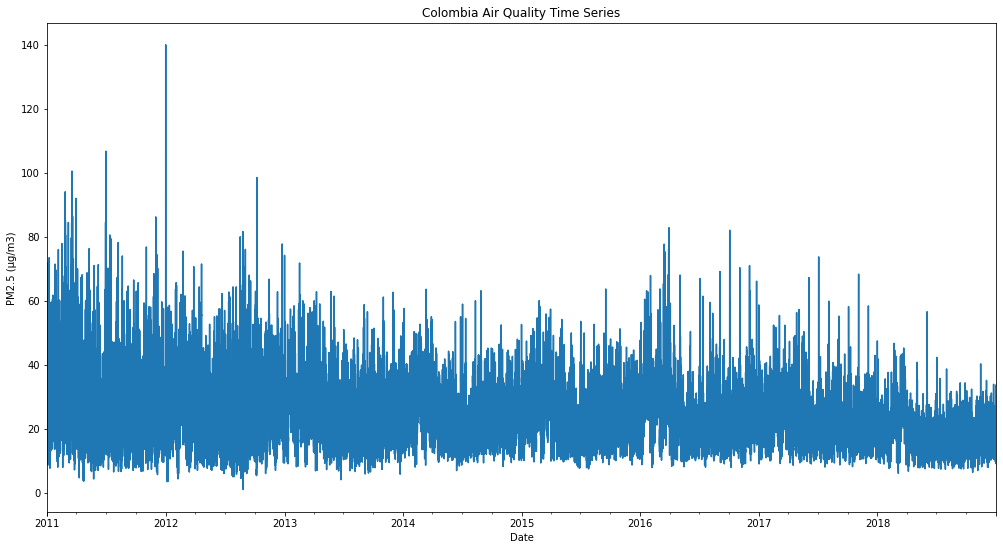

In [ ]:
## Serie plot
(df['PM2.5']
 .plot(
     kind = 'line',
     xlabel = 'Date',
     ylabel = 'PM2.5 (µg/m3)',
     title = "Colombia Air Quality Time Series",
     figsize =(17,9)
 )
);

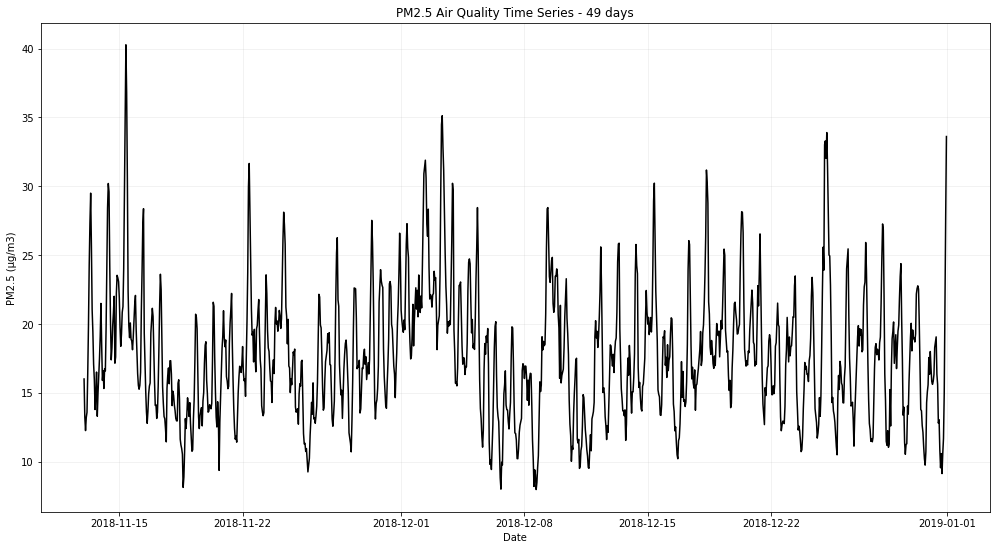

In [ ]:
## Air Quality in the last 49 days
plot_n_last_days(df, 'PM2.5', 49)

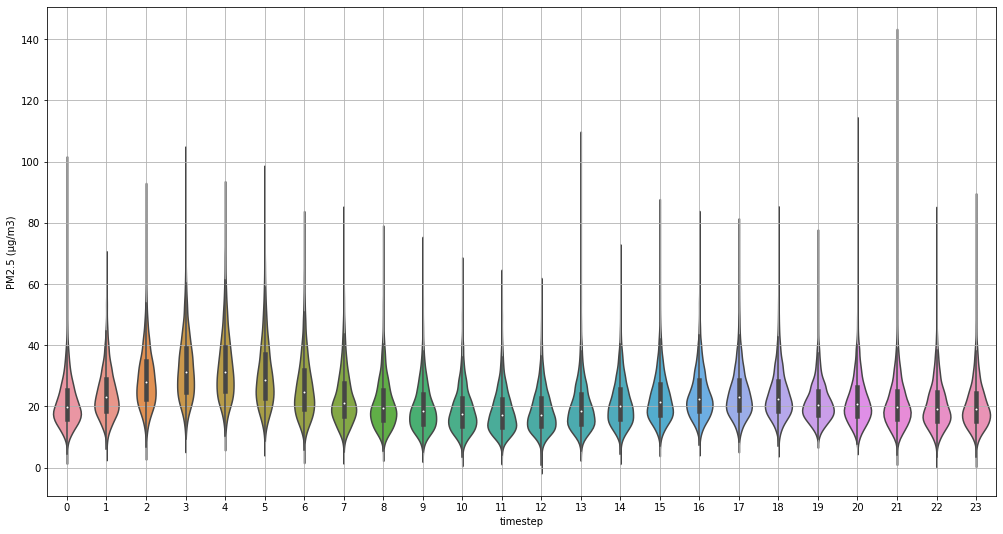

In [ ]:
# Violin plot of PM2.5 reading by hours
violin_plots(x = df.index.hour, y = df['PM2.5'])

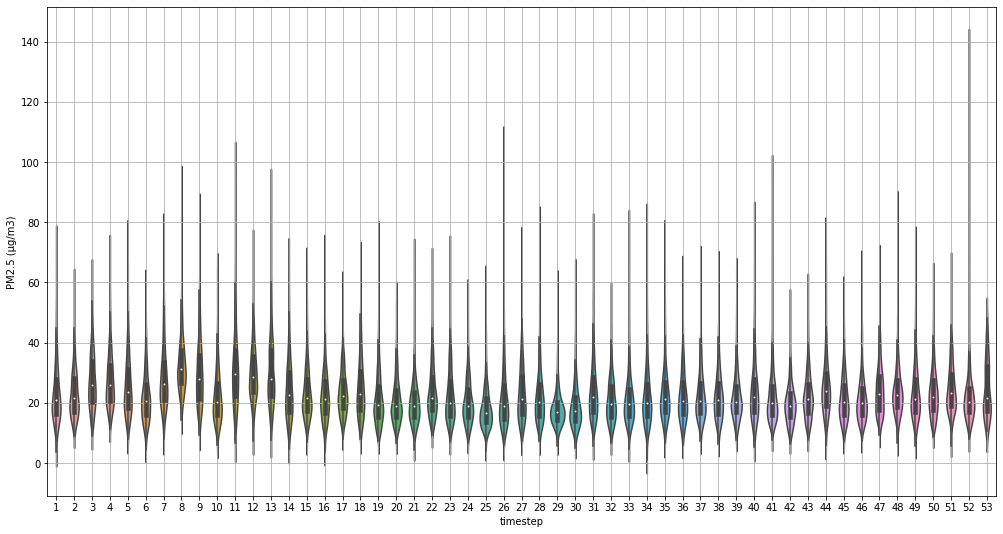

In [ ]:
# Violin plot of PM2.5 reading by weeks
violin_plots(x = df.index.week, y = df['PM2.5'])

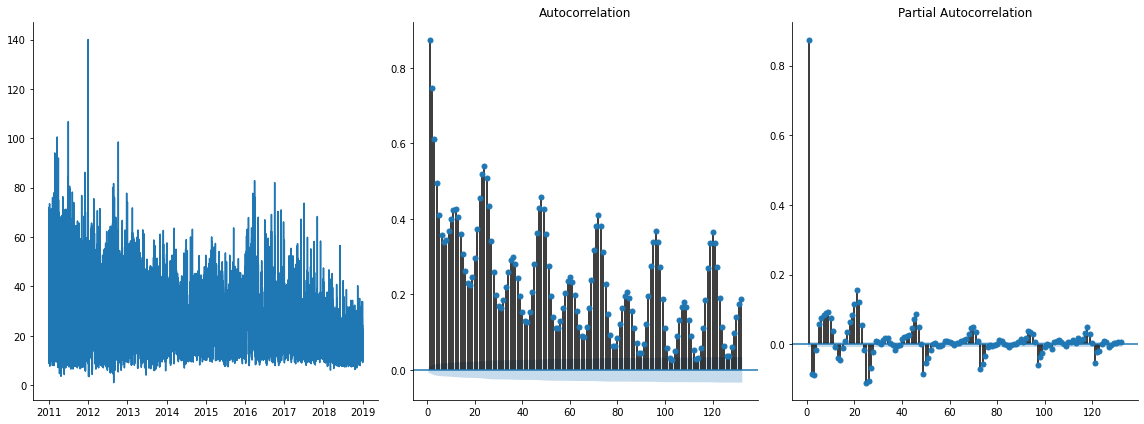

In [ ]:
## Autocorrelation plot
autocorrelation_plot(df, lags = 132)

#### **Observations**.

Scatter Maplot
- In the scatter map plot, we can see that all observations (PM2.5 concentrations) get together mainly in the Andean region from Colombia, with levels of PM2.5 concentration majority less than 80 µg/m3.    

Raw time series plot
- The air quality time series presents a clear seasonality, with minimum and maximum values that oscillate in an hour time scale.

Violin plots
- The violin plot confirms the seasonality present in the time series (view in the raw time series plots).
- With the violin charts on an hourly time scale, we can also see that PM2.5 concentration levels are higher in the first few hours of reading.

Autocorrelation plots
- In the autocorrelation chart and the partial autocorrelation chart, we can see that the PM2.5 concentration readings in Colombian air show a strong autocorrelation with 132 lag times.


#### **Data preprocessing**

- Scaler the data (MinMaxScaler)
- Split the time series data into train, val, test set (80:10:10)  

In [ ]:
## MinMaxScaler 
mm = MinMaxScaler(feature_range =(0,1))
forecast_series = mm.fit_transform(np.array(df)).reshape(-1,1)

In [ ]:
## Preprocessing the data
def get_keras_format(serie):
    """
    Convert a serie to numpy array of shape[n_samples, time_steps, features]
    """
    serie = np.array(serie)
    return serie.reshape(serie.shape[0], serie.shape[1], 1)

## Train and test set 
def train_test_data(input_hours, sample_gap = 3):
    
    global forecast_series 
    
    ##Splits
    split_1 = round(len(forecast_series)*.8)
    split_2 = round(len(forecast_series)*.9)
    ## train and test set
    train_set = forecast_series[:split_1]
    val_set = forecast_series[split_1:split_2]
    test_set = forecast_series[split_2:]
    
    ## X_train and y_train
    X_train , y_train = [],[]
    
    for i in range(0, train_set.shape[0]-input_hours, sample_gap):
        X_train.append(train_set[i:i+input_hours])
        y_train.append(train_set[i])
        
    X_train = get_keras_format(X_train)
    y_train = np.array(y_train)

    ## X_val and y_val
    X_val , y_val = [],[]
    
    for i in range(0, val_set.shape[0]-input_hours):
        X_val.append(val_set[i:i+input_hours])
        y_val.append(val_set[i])
        
    X_val = np.array(X_val)
    X_val = X_val.reshape(X_val.shape[0], X_val.shape[1],1)
    y_val = np.array(y_val)
    
    ## X_test and y_test
    X_test, y_test = [], []
    
    for i in range(0, test_set.shape[0]-input_hours):
        X_test.append(test_set[i:i+input_hours])
        y_test.append(test_set[i])
    
    X_test = get_keras_format(X_test)
    y_test = np.array(y_test)

    return X_train,X_val, X_test,y_train, y_val, y_test 

In [ ]:
input_hours = 24 # take 24 time steps in order to predict the next time step

X_train, X_val, X_test,y_train, y_val, y_test = train_test_data(input_hours)

In [ ]:
## Training and test data dimension
print('Training input shape: {}'.format(X_train.shape))
print('Training output shape: {}'.format(y_train.shape))
print('Validation input shape: {}'.format(X_val.shape))
print('Validation output shape: {}'.format(y_val.shape))
print('Test input shape: {}'.format(X_test.shape))
print('Test output shape: {}'.format(y_test.shape))

Training input shape: (18693, 24, 1)
Training output shape: (18693, 1)
Validation input shape: (6989, 24, 1)
Validation output shape: (6989, 1)
Test input shape: (6989, 24, 1)
Test output shape: (6989, 1)


#### **Modeling**

- Distributed Training Strategy
  - One Divece Strategy
- GRU model 
  - Batch Size = 128
  - Epochs = 300
  - Nadam optimizer with a 0.001 base learning rate

- LSTM model 
  - Batch Size = 128
  - Epochs = 300
  - Nadam optimizer with a 0.001 base learning rate

- Model performance with the validation set
  - Loss and accuracy plots

- Model (the best model) performance with the test set 
  - Metrics:
    - Mean Square Error

In [ ]:
## Choose a GPU device
devices = tf.config.list_physical_devices('GPU')

## Name
gpu_name = 'GPU:0'

## Define the strategy
strategy = tf.distribute.OneDeviceStrategy(device=gpu_name)

##### **Training the LSTM and GRU models**
- Callbacks
  - LearningRateScheduler

- Compile the models under the strategy scope
- Models fit

In [ ]:
## Callbacks
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
## Setting lr for different number of epochs
def lr_schedule(epoch):
  lr = 1e-3
  if epoch > 100:
    lr *= 1e-1
  elif epoch > 190:
    lr *= 1e-2
  elif epoch > 250 :
    lr *= 1e-3
  return lr
## Callbacks
schedule = LearningRateScheduler(lr_schedule)
#earlystopping = EarlyStopping(monitor = "val_loss", patience = 40, mode ='min')

##### **LSTM model**
Long Short Term Memory Network (LSTM) is an advanced RNN, a sequential network, that allows information to persist. It is capable of handling the vanishing gradient problem faced by RNN. A recurrent neural network is also known as RNN is used for persistent memory.

A common LSTM unit is composed of a cell, an input gate, and output gate and a forget gate. The cell remembers values over arbitrary time intervals and the three gates regualte the flow of information into and out of the cell.

![alt lstm](https://miro.medium.com/max/1400/1*lSDKRennQMpJFL4xxJHloQ.png)
<a href = 'https://medium.com/analytics-vidhya rnn-vs-gru-vs-lstm-863b0b7b1573'> Image source </a>

LSTM cell architecture

In [ ]:
with strategy.scope():
    
    model_lstm = Sequential([
        LSTM(500, input_shape = (X_train.shape[1],1), return_sequences = True, 
            kernel_initializer ="he_normal", dropout = 0.2),
        BatchNormalization(),
        LSTM(500, input_shape = (X_train.shape[1],1), return_sequences = True,
            kernel_initializer ="he_normal", dropout = 0.2),
        BatchNormalization(),
        LSTM(500, input_shape = (X_train.shape[1],1),
            kernel_initializer ="he_normal", dropout = 0.2),
        BatchNormalization(),
        Dense(500, kernel_initializer ="he_normal" ),
        Dropout(0.2),
        Dense(1)
    ]
    )
    ##Summary
    model_lstm.summary()
    
    ##Compile
    model_lstm.compile(
        optimizer = Nadam(learning_rate = lr_schedule(0)),
        loss = 'mse',
        metrics = ['mae']
    )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 500)           1004000   
                                                                 
 batch_normalization (BatchN  (None, 24, 500)          2000      
 ormalization)                                                   
                                                                 
 lstm_1 (LSTM)               (None, 24, 500)           2002000   
                                                                 
 batch_normalization_1 (Batc  (None, 24, 500)          2000      
 hNormalization)                                                 
                                                                 
 lstm_2 (LSTM)               (None, 500)               2002000   
                                                                 
 batch_normalization_2 (Batc  (None, 500)              2

In [ ]:
# epochs and batchs
epochs = 300
batch_size = 128
## Fit the model
hist_lstm = model_lstm.fit(
    X_train, y_train,
    steps_per_epoch = len(X_train) // batch_size,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val, y_val),
    validation_steps = len(X_val) // batch_size,
    verbose = 0,
    callbacks = [schedule]
)

##### **LSTM model performance evaluation**

- metric and loss plots

loss_train : 0.001548207481391728
mae_train : 0.03662490472197533
loss_val : 0.00101901323068887
mae_val : 0.03021267056465149


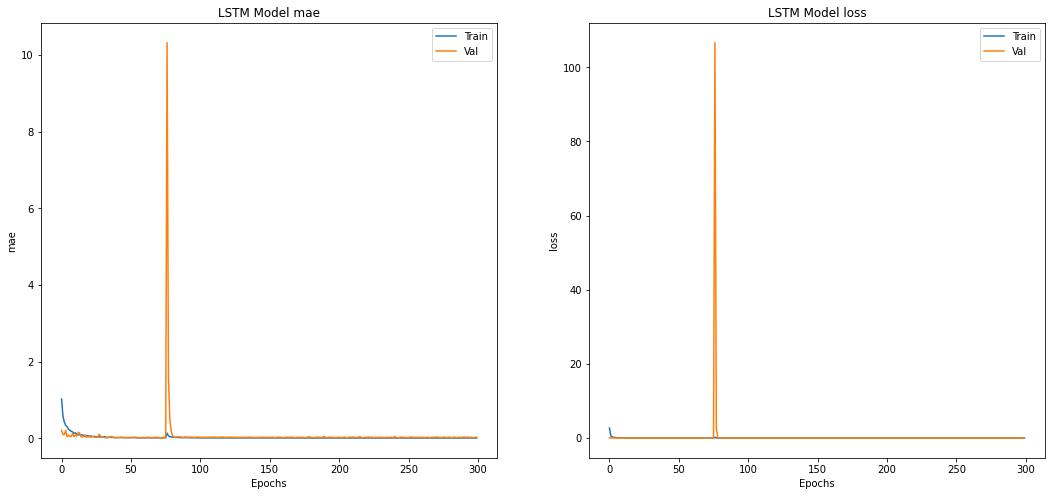

In [ ]:
## loss and metric plot
fig, ax = plt.subplots(1, 2, figsize=(18,8))
ax.ravel()

for i, met in enumerate(['mae', 'loss']):
  ax[i].plot(hist_lstm.history[met])
  ax[i].plot(hist_lstm.history['val_'+met])
  ax[i].set_title(f"LSTM Model {met}")
  ax[i].set_xlabel('Epochs')
  ax[i].set_ylabel(met)
  ax[i].legend(['Train', 'Val'])


#-------- Train set-------------
model_train_ = model_lstm.evaluate(X_train, y_train, verbose=0)
for metric, val in zip(model_lstm.metrics_names, model_train_):
  print(f"{metric}_train" + f" : {val}")
#----------Validation set-------
model_val_ = model_lstm.evaluate(X_val, y_val, verbose=0)
for metric, val in zip(model_lstm.metrics_names, model_val_):
  print(f"{metric}_val" + f" : {val}")

###### **GRU model**

Gated recurrent units(GRUs) cell are a gating mechanism in recurrenct neural networks, introduced in 2014 by Kyunghyun Cho et el. The GRU is like a Long Short-Term Memory (LSTM), but has fewer parameters than LSTM, as it lacks an output gate (it contains only 2 gates Reset and Update).

![Gru model](https://miro.medium.com/max/1724/1*GSZ0ZQZPvcWmTVatAeOiIw.png)

<a href = 'https://medium.com/analytics-vidhya rnn-vs-gru-vs-lstm-863b0b7b1573'> Image source </a>


GRU cell architecture

In [ ]:
with strategy.scope():
    
    model_gru = Sequential([
        GRU(500, input_shape = (X_train.shape[1],1), return_sequences = True, 
            kernel_initializer ="he_normal", dropout = 0.2),
        BatchNormalization(),
        GRU(500, input_shape = (X_train.shape[1],1), return_sequences = True, 
            kernel_initializer ="he_normal", dropout = 0.2),
        BatchNormalization(),
        GRU(500, input_shape = (X_train.shape[1],1),
            kernel_initializer ="he_normal", dropout = 0.2),
        BatchNormalization(),
        Dense(500, kernel_initializer ="he_normal" ),
        Dropout(0.2),
        Dense(1),
    ]
    )
    ##Summary
    model_gru.summary()
    
    ##Compile
    model_gru.compile(
        optimizer = Nadam(learning_rate = lr_schedule(0)),
        loss = 'mse',
        metrics = ['mae']
    )

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 24, 500)           754500    
                                                                 
 batch_normalization_3 (Batc  (None, 24, 500)          2000      
 hNormalization)                                                 
                                                                 
 gru_1 (GRU)                 (None, 24, 500)           1503000   
                                                                 
 batch_normalization_4 (Batc  (None, 24, 500)          2000      
 hNormalization)                                                 
                                                                 
 gru_2 (GRU)                 (None, 500)               1503000   
                                                                 
 batch_normalization_5 (Batc  (None, 500)             

In [ ]:
## Fit or training the model
hist_gru = model_gru.fit(
    X_train, y_train,
    steps_per_epoch = len(X_train) // batch_size,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val, y_val),
    validation_steps = len(X_val) // batch_size,
    verbose = 0,
    callbacks = [schedule]
)

##### **GRU model performance evaluation**

- metric and loss plots

loss_train : 0.0013950718566775322
mae_train : 0.03523300215601921
loss_val : 0.000975844799540937
mae_val : 0.030285479500889778


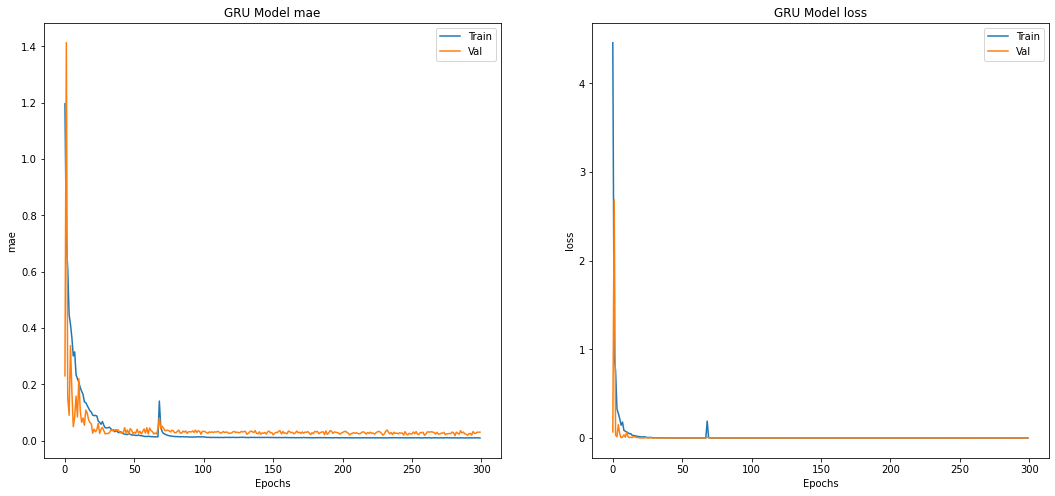

In [ ]:
## loss and metric plot
fig, ax = plt.subplots(1, 2, figsize=(18,8))
ax.ravel()

for i, met in enumerate(['mae', 'loss']):
  ax[i].plot(hist_gru.history[met])
  ax[i].plot(hist_gru.history['val_'+met])
  ax[i].set_title(f"GRU Model {met}")
  ax[i].set_xlabel('Epochs')
  ax[i].set_ylabel(met)
  ax[i].legend(['Train', 'Val'])

#-------- Train set-------------
model_train = model_gru.evaluate(X_train, y_train, verbose=0)
for metric, val in zip(model_gru.metrics_names, model_train):
  print(f"{metric}_train" + f" : {val}")
#----------Validation set-------
model_val = model_gru.evaluate(X_val, y_val, verbose=0)
for metric, val in zip(model_gru.metrics_names, model_val):
  print(f"{metric}_val" + f" : {val}")

#### **Overall observations of modeling process**
- The LSTM and GRU models achieved good performance with the training set and the validation set, limiting the overfitting possibilities on the training set.
- The performance of the GRU model was slightly better than the LSTM model. It  can see this with the following loss functions values reached by each model:
   - GRU loss funtion values:
      - Training set: 0.0013
      - Validation set: 0.0009
   - LSTM loss funtion values:
      - Training set: 0.0015
      - Validation set: 0.0010

#### **Making predictions**

- LSTM model forecast plot
- GRU model forecast plot

In [ ]:
## Forecast
y_pre_lstm = model_lstm.predict(X_test)
y_pre_gru = model_gru.predict(X_test)
y_pre_lstm  = pd.DataFrame(mm.inverse_transform(y_pre_lstm), columns= ['LSTM Forecast'])
y_pre_gru = pd.DataFrame(mm.inverse_transform(y_pre_gru), columns= ['Gru Forecast'])
##
y_test_iv = pd.DataFrame(mm.inverse_transform(y_test), columns=['Target series'])

In [ ]:
# LSTM model forecast plot
## Dataframe
df_pre_test_lstm = pd.concat([y_test_iv,y_pre_lstm], axis = 1)
## Plot
fig = px.line(df_pre_test_lstm, labels= {'value': 'PM2.5'})

fig.update_layout(
    title = 'Colombia Air Quality Forecast(LSTM RNN)',
    xaxis_title = 'Time Steps',
    yaxis_title = 'PM2.5 Level'

)

In [ ]:
#GRU model forecast plot
## Dataframe
df_pre_test_gru = pd.concat([y_test_iv,y_pre_gru], axis = 1)
## Plot
fig = px.line(df_pre_test_gru, labels= {'value': 'PM2.5'})

fig.update_layout(
    title = 'Colombia Air Quality Forecast(GRU RNN)',
    xaxis_title = 'Time Steps',
    yaxis_title = 'PM2.5 Level'

)

#### **Save the models**

In [ ]:
def save_model(model, file_path):
  model.save(file_path, save_format= 'h5')

save_model(model_lstm, 'LSTM_model')
save_model(model_gru, 'GRU_model')